In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 

# Fast Fourier Transform for Denoising
from tensorflow.signal import fft

# Outlier Detection Plotting
import seaborn as sn
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import scipy.stats as stats
%matplotlib inline

In [2]:
all_nifty_data = pd.read_csv(r"C:\Users\zzsmathur\Downloads\NIFTY50_all.csv")

# Retrieving Wipro stock data from the entire Nifty dataset
nifty_wipro = all_nifty_data[all_nifty_data["Symbol"]=="WIPRO"].reset_index()
nifty_wipro.drop('index',inplace=True,axis=1)
nifty_wipro.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,WIPRO,EQ,2522.40,2724.00,2724.20,2724.00,2724.20,2724.20,2724.17,1599,4.355942e+11,NaN,NaN,NaN
1,2000-01-04,WIPRO,EQ,2724.20,2942.15,2942.15,2942.15,2942.15,2942.15,2942.15,4392,1.292192e+12,NaN,NaN,NaN
2,2000-01-05,WIPRO,EQ,2942.15,2942.15,3177.55,2715.00,3000.00,2990.10,3063.86,132297,4.053390e+13,NaN,NaN,NaN
3,2000-01-06,WIPRO,EQ,2990.10,3144.70,3183.00,2790.00,2915.00,2932.25,2962.41,72840,2.157822e+13,NaN,NaN,NaN
4,2000-01-07,WIPRO,EQ,2932.25,2751.00,2751.00,2697.70,2697.70,2697.70,2697.95,10110,2.727630e+12,NaN,NaN,NaN


In [3]:
# Lets start by dropping some of the columns which do not add much value to the model
nifty_wipro.drop(['Symbol','Series'],inplace=True,axis=1)

## Missing Value Imputation

In [4]:
# Checking which columns have missing values again
nifty_wipro.isnull().sum()

Date                     0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2850
Deliverable Volume     509
%Deliverble            509
dtype: int64

It seems that Trades column consists of huge number of missing values, whereas Deliverable Volume & %Deliverble contain smaller amounts of missing values. Let's express the amount of missing values, relative to the entire dataset, in order to a get better about the magnitude of missing data.

In [5]:
(nifty_wipro.isnull().sum()/len(nifty_wipro))*100

Date                   0.000000
Prev Close             0.000000
Open                   0.000000
High                   0.000000
Low                    0.000000
Last                   0.000000
Close                  0.000000
VWAP                   0.000000
Volume                 0.000000
Turnover               0.000000
Trades                53.712778
Deliverable Volume     9.592914
%Deliverble            9.592914
dtype: float64

The expressed percentage of missing values in Trades is around `54%`!. This much of missing data means that this time series will be able to provide significant contribution in the model we will create. Furthermore, trying to impute the missing values will only bring about `bias & misleading information` in the Trends column. So, we can drop this column.

In [6]:
nifty_wipro.drop('Trades',inplace=True,axis=1)

As for the other 2 columns, we can impute the missing values for each since the amount of missing values is not very large `relatively`. We can start by diving deeper into the distribution of the values for each series.

### Checking Distribution & Q-Q Plot

Skewness of Deliverable Volume:  7.525274955729543
Skewness of &Deliverble:  -0.31720713669946693


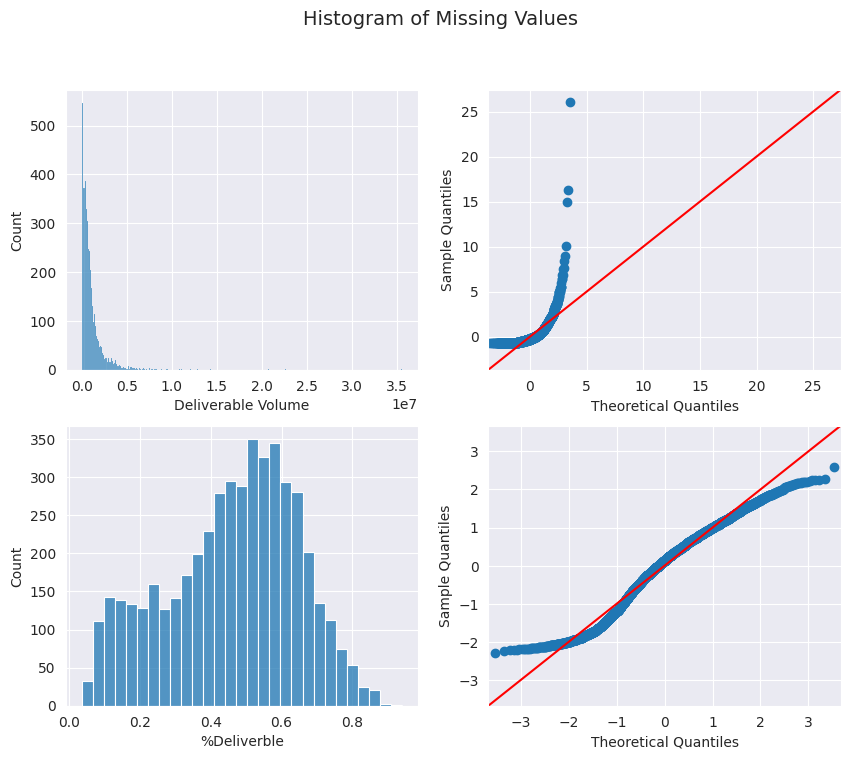

In [7]:
print('Skewness of Deliverable Volume: ', nifty_wipro['Deliverable Volume'].skew())
print('Skewness of &Deliverble: ', nifty_wipro['%Deliverble'].skew())
with sn.axes_style('darkgrid'):
    fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2,figsize=(10,8))
    fig.suptitle('Histogram of Missing Values',fontsize=14)
    ax0 = sn.histplot((nifty_wipro['Deliverable Volume']),ax=ax0)
    ax1 = sm.qqplot(nifty_wipro['Deliverable Volume'].dropna(),line='45',fit=True,dist=stats.norm,ax=ax1)
    ax2 = sn.histplot((nifty_wipro['%Deliverble']),ax=ax2)
    ax3 = sm.qqplot(nifty_wipro['%Deliverble'].dropna(),line='45',fit=True,dist=stats.norm,ax=ax3)

Taking into account the skewness & the Quantile-Quantile plot of `%Deliverble (right)`, we can conclude that this series is normally distributed, with slight degree of left skewness. Although, the skewness lies between -0.5 and 0.5, we can experiment with imputation methods of `Normally Distributed` & `Left Skewed Distribution` to see what works well.

For `Deliverable Volume`, the QQ-Plot & the skewness show high amounts of `right-skewness` present in the series. This indicates that we cannot use the same methods for imputation as we did for %Deliverble.

### Outlier Analysis
For filling in missing values, it is imperitive to consider the presence of outliers. This analysis will play a direct hand in selecting which methods we will choose for imputing the missing values.

Plotting a boxplot to check the presence of outliers in each of the time series.
    An extreme value is considered to be an `outlier` if it is at least `1.5 interquartile ranges` below the first quartile, or at least 1.5 interquartile ranges above the third quartile.

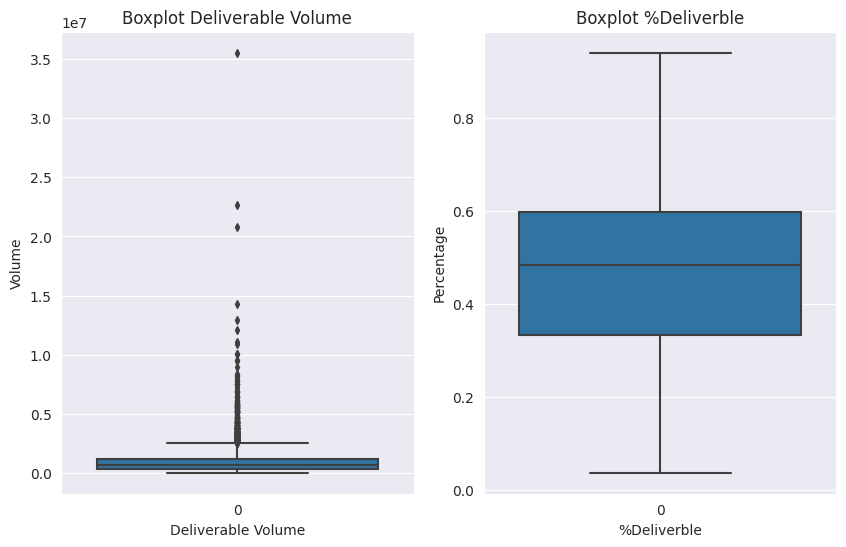

In [8]:
# Box plot
with sn.axes_style('darkgrid'):
    fig ,(ax0,ax1) = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
    ax0 = sn.boxplot(nifty_wipro['Deliverable Volume'],ax=ax0,fliersize=4.0)
    ax0.set_title('Boxplot Deliverable Volume')
    ax0.set_xlabel('Deliverable Volume')
    ax0.set_ylabel('Volume')
    
    ax1 = sn.boxplot(nifty_wipro['%Deliverble'],ax=ax1,fliersize=4.0)
    ax1.set_title('Boxplot %Deliverble')
    ax1.set_xlabel('%Deliverble')
    ax1.set_ylabel('Percentage')

Since, there are outliers present in the time series `mean imputation will not be a good approach`. This is because the mean is heavily affected by the presence of outliers & by replacing the missing values with the mean, we would be adding biased & skewed data points to the series.

A more popular approach for imputation is by using `linear interpolation`. 

In [9]:
nifty_wipro['Deliverable Volume'] = nifty_wipro['Deliverable Volume'].interpolate(limit_direction='both', method='linear')
nifty_wipro['%Deliverble'] = nifty_wipro['%Deliverble'].interpolate(limit_direction='both', method='linear')

In [10]:
# Checking missing values 
nifty_wipro.isnull().sum()

Date                  0
Prev Close            0
Open                  0
High                  0
Low                   0
Last                  0
Close                 0
VWAP                  0
Volume                0
Turnover              0
Deliverable Volume    0
%Deliverble           0
dtype: int64

In [11]:
#### Areas to continue
# 1. De-Trending
# 2. Seasonal Adjustment
# 3. Smoothening using Fouier Transform
# 4. Feature Engineering

## Trending Analysis & De-Trending

In [272]:
# Fitting multiple lines of degrees to estimate the trend of the time series

# Helper function for fitting the lines
def trend_fit(column_name):

    ######## Line Fitting ########
    xaxis = range(0,len(nifty_wipro))
    
    # Linear Trend
    coefficients = np.polyfit(range(0,len(nifty_wipro)),nifty_wipro[column_name],1)
    f1 = np.poly1d(coefficients)
    linear_trend = f1(xaxis)
    
    # Quadratic Trend (degree-2)
    coefficients = np.polyfit(range(0,len(nifty_wipro)),nifty_wipro[column_name],2)
    f2 = np.poly1d(coefficients)
    quadratic_trend = f2(xaxis)

    # Cubic Trend
    coefficients = np.polyfit(range(0,len(nifty_wipro)),nifty_wipro[column_name],3)
    f3 = np.poly1d(coefficients)
    cubic_trend = f3(xaxis)
    
    ######## Rolling Average ########
    roll_avg_12 = nifty_wipro[column_name].rolling(12).mean()
    roll_avg_24 = nifty_wipro[column_name].rolling(24).mean()
    roll_avg_36 = nifty_wipro[column_name].rolling(36).mean()
    roll_avg_48 = nifty_wipro[column_name].rolling(48).mean()

    with sn.axes_style("darkgrid"):
        fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2,figsize=(18,7))
        ax0.plot(xaxis,linear_trend)
        ax0.plot(xaxis,quadratic_trend)
        ax0.plot(xaxis,cubic_trend)
        ax0.plot(xaxis, nifty_wipro[column_name],color="lightblue")
        ax0.legend(['Linear','Quadratic','Cubic','Original']);
        ax0.set_title('Trend Fitting', fontweight ="bold",fontsize=12)
        ax1.plot(roll_avg_12)
        ax1.plot(roll_avg_24)
        ax1.plot(roll_avg_36)
        ax1.plot(roll_avg_48)
        ax1.legend(['12-Days','24-Days','36-Days','48-Days']);
        ax1.set_title('Rolling Average', fontweight ="bold",fontsize=12)
        

# Helper function for Time Series Decomposition
def decompose_ts(df,column_name,time_period):
    result = seasonal_decompose((df[column_name]), model='additive', period=time_period)
    with sn.axes_style("darkgrid"):
        fig,ax = plt.subplots(nrows=3,ncols=1, figsize=(15,8))
        ax[0] = sn.lineplot(result.trend,ax=ax[0],color="orange")
        ax[1] = sn.lineplot(result.seasonal,ax=ax[1],color="blue")
        ax[2] = sn.lineplot(result.resid,ax=ax[2],color="green")


# Helper function to display the differenced version of the time series
def display_differenced(df,column):
    with sn.axes_style("darkgrid"):
        fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(15,8))
        ax[0] = sn.lineplot(df[column],ax=ax[0],color="red")
        ax[0].set_title("Original Time Series",fontsize=16)
        ax[1] = sn.lineplot(df[column].diff().dropna(),ax=ax[1], color='orange')
        ax[1].set_title("Differenced Time Series",fontsize=16)

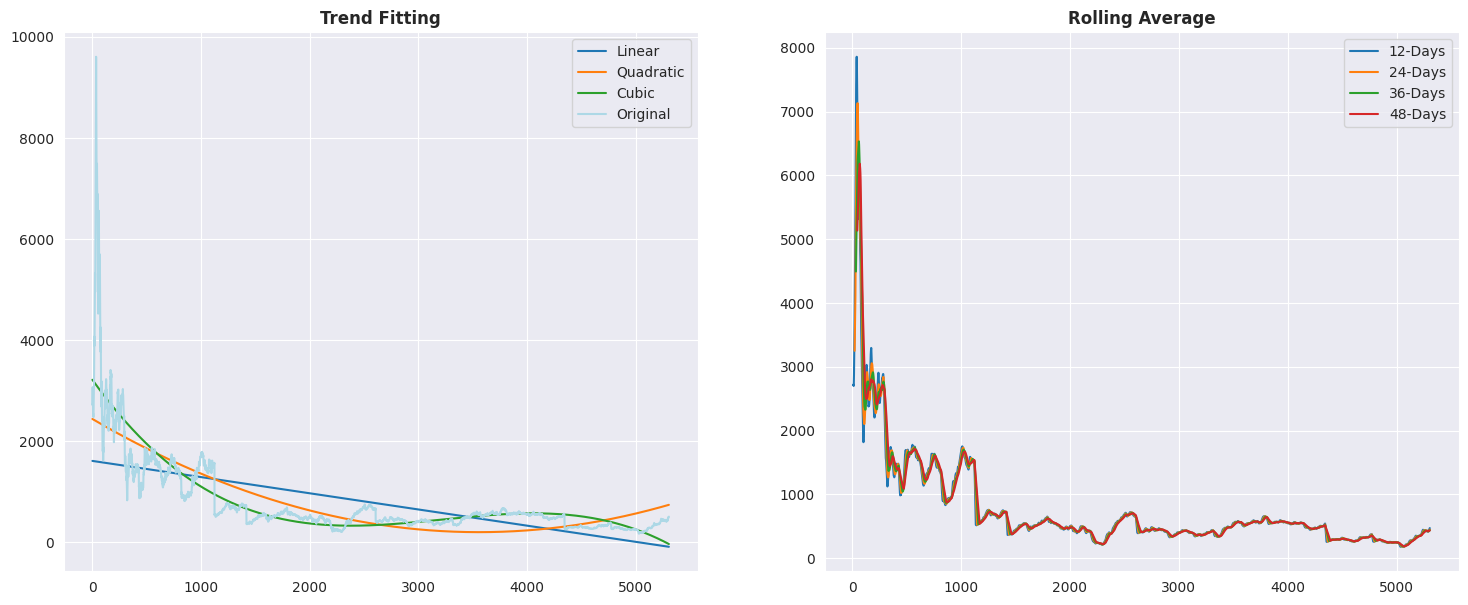

In [279]:
trend_fit('VWAP')

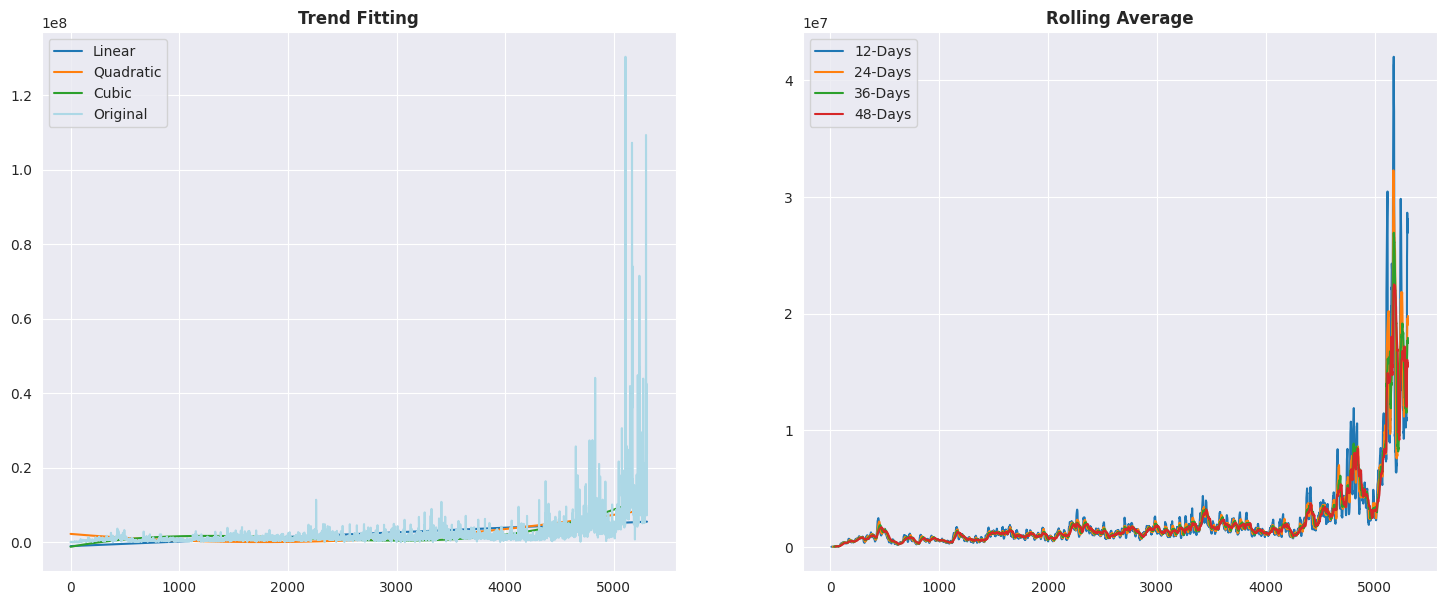

In [275]:
trend_fit('Volume')

In order to gather some information about the nature of the trend in the time series. The first approach to gain some idea about the trend is to try fitting a linear line throught the time series. The linear line was not a suitable fit for the trend, since the `error rate was very very high`, almost not catching the trend. When experimenting with higher degrees of polynomials, cubic degrees (n=3), was starting to capture the trends of the series.
In the right side, is a plot of the moving average calculating across multiple intervals. This plot is used for identifying short term pattern present in the data.

`Detrending` is `removing a trend from a time series`; a trend usually refers to a change in the mean over time. When you detrend data, you remove an aspect from the data that you think is causing some kind of distortion. For example, you might detrend data that shows an overall increase, in order to see subtrends. Usually, these subtrends are seen as fluctuations on a time series graph.

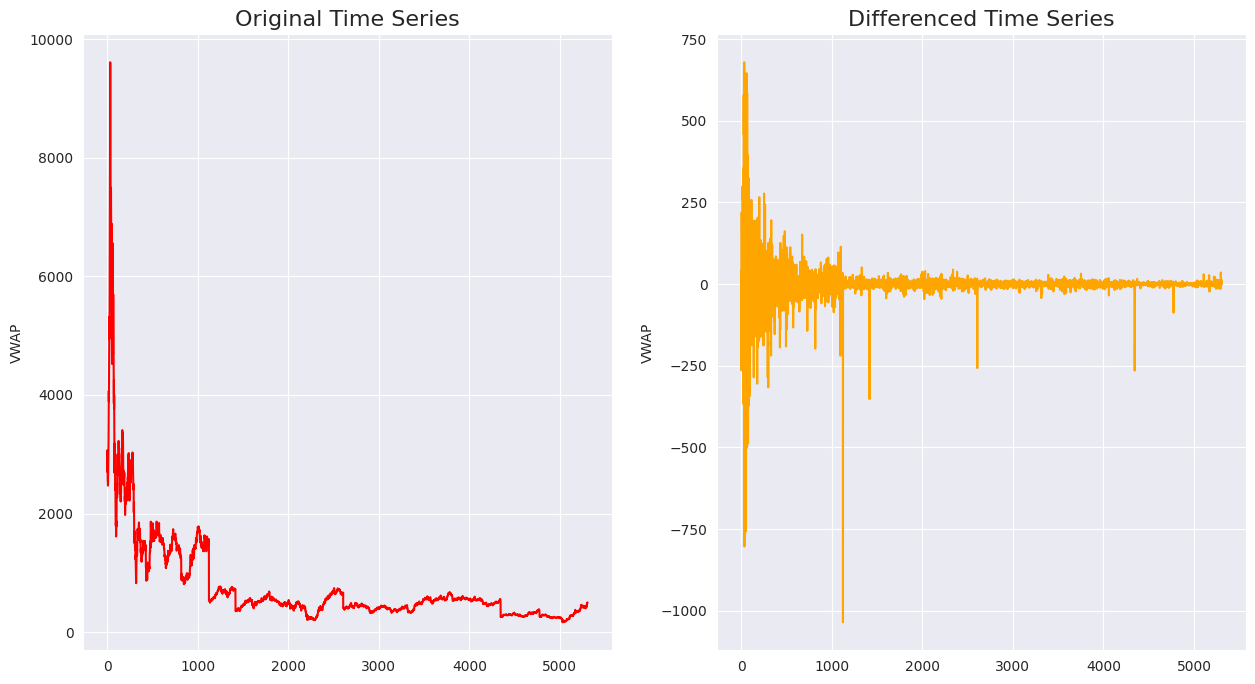

In [82]:
display_differenced(nifty_wipro,"VWAP")

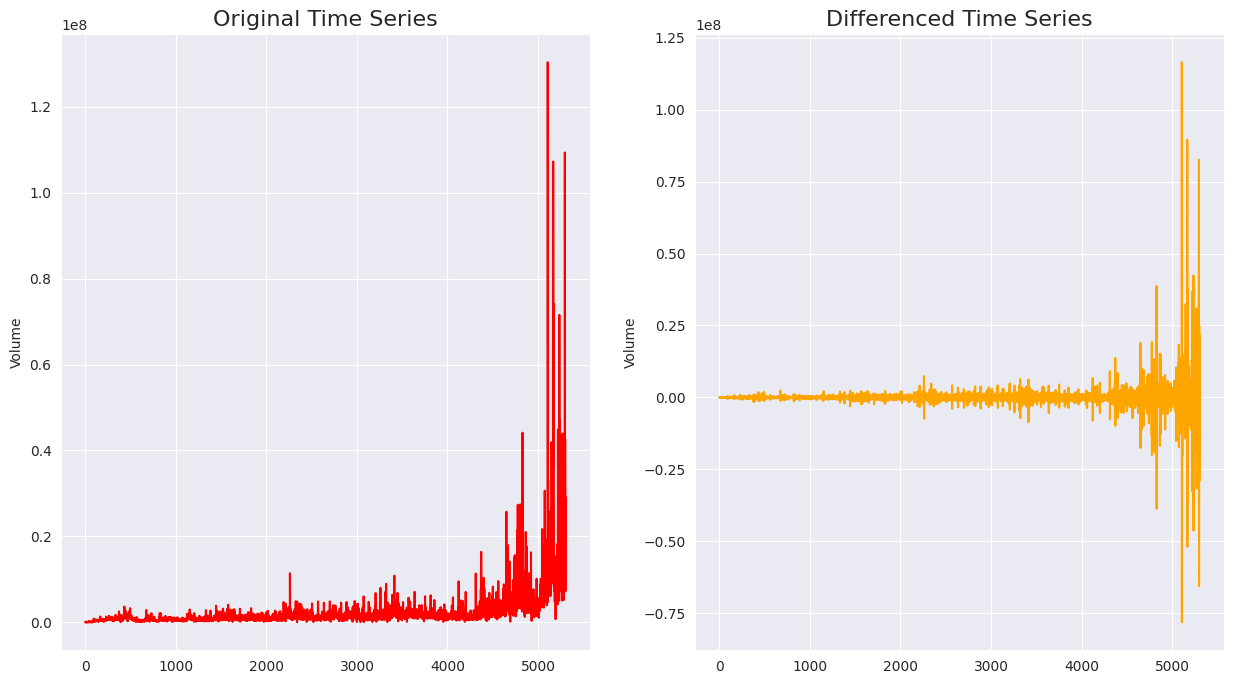

In [274]:
display_differenced(nifty_wipro,"Volume")

From these plots, we can say that the time series has been detrended and that the differencing method worked well on this dataset. We can also experiment with other degrees of differenciation, if this approach would have produced less desirable results. 

Differencing all the time series in the data:

In [276]:
nifty_wipro

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Deliverable Volume,%Deliverble
0,2000-01-03,2522.40,2724.00,2724.20,2724.00,2724.20,2724.20,2724.17,1599,4.355942e+11,66955.0,0.0505
1,2000-01-04,2724.20,2942.15,2942.15,2942.15,2942.15,2942.15,2942.15,4392,1.292192e+12,66955.0,0.0505
2,2000-01-05,2942.15,2942.15,3177.55,2715.00,3000.00,2990.10,3063.86,132297,4.053390e+13,66955.0,0.0505
3,2000-01-06,2990.10,3144.70,3183.00,2790.00,2915.00,2932.25,2962.41,72840,2.157822e+13,66955.0,0.0505
4,2000-01-07,2932.25,2751.00,2751.00,2697.70,2697.70,2697.70,2697.95,10110,2.727630e+12,66955.0,0.0505
...,...,...,...,...,...,...,...,...,...,...,...,...
5301,2021-04-26,475.70,479.40,483.85,477.00,482.00,480.30,479.77,9314644,4.468927e+14,3081057.0,0.3308
5302,2021-04-27,480.30,481.40,487.00,481.00,483.85,485.05,484.07,7209467,3.489910e+14,2548269.0,0.3535
5303,2021-04-28,485.05,485.85,493.20,481.25,488.65,489.30,487.55,9615534,4.688083e+14,3254249.0,0.3384
5304,2021-04-29,489.30,492.70,492.80,485.70,489.00,489.85,489.45,7641133,3.739989e+14,2534352.0,0.3317
